# Principal Components Analysis

In [2]:
import os
import re
import datetime 

import pandas as pd
import numpy as np
import pandas_gbq
import janitor
import numpy as np
from sklearn.decomposition import PCA

# Do our imports for the code
from google.cloud import bigquery
from google.oauth2 import service_account

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

# Authentication to GBQ Dataset

In [3]:
# These first two values will be different on your machine. 
service_path = ""  # change this to your file path
service_file = '' # change this to your authentication information  
gbq_proj_id = '' # change this to your project. 

# And this should stay the same. 
private_key =service_path + service_file

In [4]:
# Now we pass in our credentials so that Python has permission to access our project.
credentials = service_account.Credentials.from_service_account_file(service_path + service_file)

In [5]:
# And finally we establish our connection
client = bigquery.Client(credentials = credentials, project=gbq_proj_id)

In [6]:
for item in client.list_datasets() : 
    print(item.full_dataset_id)

msba-project-2022:dram_shop
msba-project-2022:wedge_dataset


# Data

Now I'll write my query that returns my required data from Google Big Query and feed the results into a pandas dataframe

In [7]:
query_1 = """SELECT
            original.customer_id as customer_id,
            itl.beverage as beverage,
            sum(gross_sales) as gross_sales
            from `umt-msba.dram_shop.dram_items_2*` as original
            INNER JOIN `umt-msba.dram_shop.item_lookup` as itl on itl.item = original.item
            where beverage in (SELECT itl.beverage,
                              from `umt-msba.dram_shop.dram_items_2*` as og
                              INNER JOIN `umt-msba.dram_shop.item_lookup` as itl on itl.item = og.item
                              group by itl.beverage
                              order by sum(gross_sales) DESC
                              LIMIT 1000)
            and customer_id IS NOT NULL
            and itl.beverage != "custom amount"
            group by customer_id, itl.beverage
            order by gross_sales DESC
            """

customers_top_1000_bevs = pandas_gbq.read_gbq(query_1,project_id = gbq_proj_id)

Downloading: 100%|██████████| 275878/275878 [00:09<00:00, 29580.22rows/s]


In [38]:
#customers_top_1000_bevs

Now that we have our dataframe let's do the pivot function

In [37]:
df_pivot = customers_top_1000_bevs.pivot(index = 'customer_id',columns = 'beverage',values = 'gross_sales').fillna(0)
#df_pivot

# Creating my PCA

In [10]:
pca = PCA(n_components=20, svd_solver='full')
pca.fit(df_pivot)

print(pca.explained_variance_ratio_)

[0.17296888 0.11254302 0.07466331 0.06660829 0.02171697 0.01768919
 0.01356676 0.01217601 0.01118948 0.01015415 0.00989252 0.00968764
 0.00853257 0.00795927 0.00775243 0.00748424 0.00705071 0.00690017
 0.00675952 0.00641103]


Now lets try to plot the first 20 components

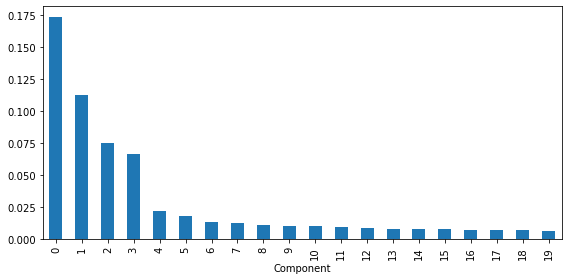

In [11]:
explained_variance = pd.DataFrame(pca.explained_variance_ratio_)
ax = explained_variance.head(20).plot.bar(legend=False, figsize=(8, 4))
ax.set_xlabel('Component')
plt.tight_layout()
plt.show()

# Analyzing Components

Now lets try to investigate the loadings of the first six components from our pca above.

In [12]:
loadings = pd.DataFrame(pca.components_[0:50, :], 
                        columns=df_pivot.columns)




This function will allows us to plot our components along with their loadings.

In [13]:
def show_component(component,cutoff=0.05) : 
    
    pc_loading = loadings.transpose().iloc[:,component-1]
    pc_loading = pc_loading.loc[pc_loading.abs() > cutoff].sort_values()
    max_pc = max(pc_loading.abs())
    colors = ['C0' if l > 0 else 'C1' for l in pc_loading]

    pc_loading.plot.bar(color = colors)
    ax = plt.gca()
    plt.axhline(y=0,c="#888888")
    ax.set_ylim(-max_pc, max_pc)
    plt.tight_layout()
    plt.xticks(rotation=45, ha='right')
    plt.show()


# Factor 1 (IPA )

In [ ]:
This factor seems to cover what the most popular items are at the dram shop. We see IPA, Kombucha, Super pills etc all
within the largest loadings. Which leads me to believe this component summarizes what people buy the most of.

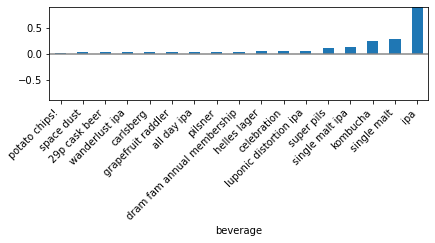

In [36]:
show_component(1,.020)

# Factor 2 (Kombucha vs IPA)

In [ ]:
This factor shows Kobucha and IPA as having the largest loadings in the component. As such this factor is probably showing
how many people drink Kombucha.

C:\Users\ofano\AppData\Local\Temp\ipykernel_16492\452570904.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


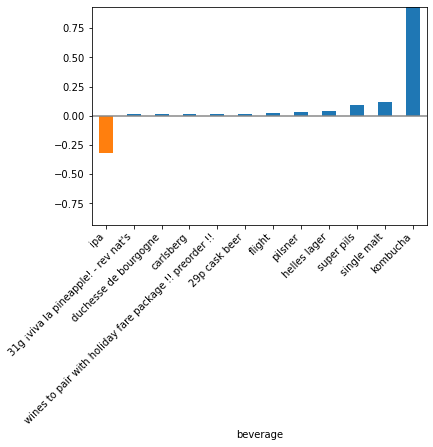

In [34]:
show_component(2,.015)

# Factor 3 (Single Malt vs IPA)

In [ ]:
This factor shows single Malt as the highest positive loading, while Kombucha and Ipa are the largest negative loadings. 
So in essence this factor is showing what the 3rd most popular item is at dram shop, Single Malt.

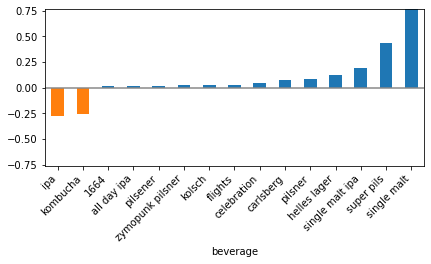

In [32]:
show_component(3,.020)

# Factor 4( Super Pils vs Single Malt)

In [ ]:
This factor shows Super pills as the highest positive loading, and Single Malt and Single malt IPA as the largest
negative loading. So I would assume this factor is defining the 4th most popular category at the dram shop.

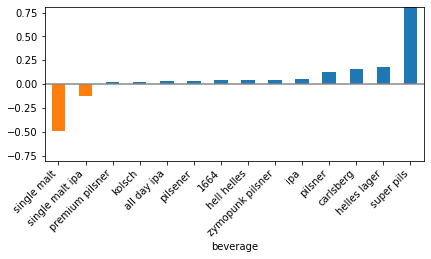

In [31]:
show_component(4,.020)

# Factor 5 (Single Malt)

In [ ]:
This factor shows Celebration, Glitz and Glam, and Dram Merch, as the largest positive loadings, while single malt and super
pils have the largest negative loadings. I would say this factor is the 5th most popular category, as these three loadings are 
very similiar and probably are representing the same thing (purchases that aren't related to beer).

C:\Users\ofano\AppData\Local\Temp\ipykernel_16492\452570904.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


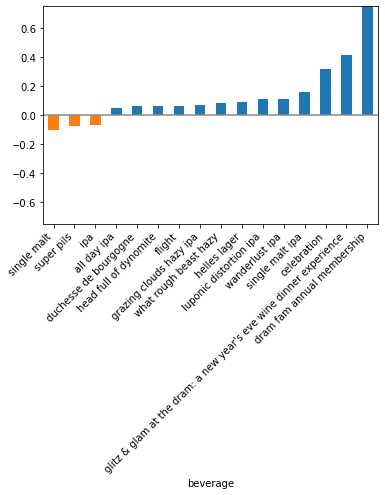

In [23]:
show_component(5,.050)

# Factor 6 (Single Malt and Single Malt)

The final factor here showed single malt Ipa as the largest positive loading while single malt was the largest negative loading.
So I would venture that this factor shows the people who only drink single malt IPA.

C:\Users\ofano\AppData\Local\Temp\ipykernel_16492\452570904.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


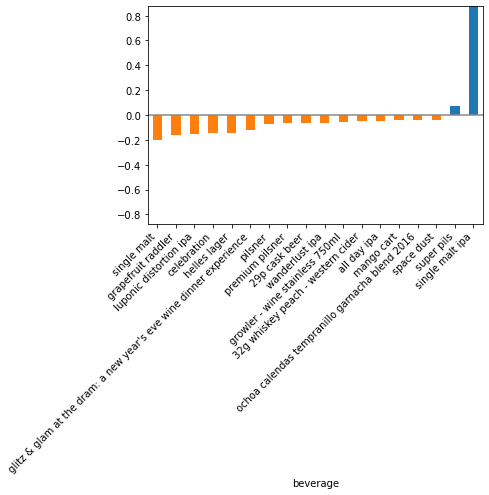

In [30]:
show_component(6,.040)